In [1]:
import math
import random
from collections import namedtuple, deque
from itertools import count

import torch
from torch import nn, optim
from torch.nn.functional import relu

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [16]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [116]:
from battleship.logic.game import Field

class ActionSpace:
    def __init__(self, env):
        self.env = env

    def sample(self):
        # Randomly sample a valid action (untried cell)
        legal = self.env.legal_actions()
        return random.choice(legal) if legal else 0  # fallback to 0 if no legal actions.

class BattleshipEnv:
    def __init__(self):
        self.size = 10
        self.n_actions = self.size * self.size
        self.n_observations = self.size * self.size
        self.enemy_field = None
        self.agent_field = None
        self.agent_view = None
        self.done = False
        self.remaining = None
        self.action_space = ActionSpace(self)


    def _get_obs(self):
        # one‑hot encode 0=unknown, 1=miss, 2=hit
        v = self.agent_view
        o0 = (v == 0).astype(np.float32)
        o1 = (v == 1).astype(np.float32)
        o2 = (v == 2).astype(np.float32)
        return np.stack([o0, o1, o2], axis=0)  # shape (3,10,10)

    def reset(self):
        self.enemy_field = Field()
        self.enemy_field.auto_place()
        self.agent_view = np.zeros((10,10), dtype=np.int8)
        self.done = False
        self.remaining = sum(s.size for s in self.enemy_field.ships)
        return self._get_obs(), {}

    def step(self, action):
        if self.done:
            raise Exception("Game is over. Call reset().")
        x, y = divmod(action, self.size)
        if self.agent_view[x, y] != 0:
            # Invalid move (already shot here)
            reward = -5.0
            self.done = True
            return self._get_obs(), reward, self.done, False, {}
        result = self.enemy_field.check((x, y))
        if result == 'hit':
            self.agent_view[x, y] = 2
            reward = 1.0
            self.remaining -= 1
        elif result == 'sank':
            self.agent_view[x, y] = 2
            reward = 5.0
            self.remaining -= 1
        else:
            self.agent_view[x, y] = 1
            reward = -1.0
        if self.remaining == 0:
            self.done = True
            reward += 100.0  # Win bonus
        return self._get_obs(), reward, self.done, False, {}

    def legal_actions(self):
        # Returns a list of valid action indices
        return [i for i in range(self.n_actions) if self.agent_view.flat[i] == 0]

In [23]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions=100):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(100, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = relu(self.layer1(x))
        x = relu(self.layer2(x))

        return self.layer3(x)

In [94]:
class DQN(nn.Module):
    def __init__(self, n_observations=1, n_actions=100):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 10 * 10, 128)
        self.fc2 = nn.Linear(128, n_actions)

    def forward(self, x):
        # x: (batch, 1, 10, 10)
        # x = x.view(x.size(0), 1, 10, 10)
        x = relu(self.conv1(x))
        x = relu(self.conv2(x))
        x = relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # flatten
        x = relu(self.fc1(x))
        return self.fc2(x)  # (batch, 100)

In [41]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [78]:
steps_done = 0
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)    # TODO: change threshold formula
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            q_values = policy_net(state)
            legal = env.legal_actions()
            mask = torch.full(q_values.shape, float('-inf'), device=device)
            mask[0, legal] = 0  # Only legal actions are unmasked
            masked_q_values = q_values + mask
            return masked_q_values.max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [108]:
lr = 1e-4
gamma = 0.99
tau = 0.005
batch_size = 128

env = BattleshipEnv()
n_observations = env.n_observations
n_actions = env.n_actions

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
memory = ReplayMemory(10000)

In [103]:
def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    # In optimize_model(), after optimizer.step():
    loss_history.append(loss.item())

In [114]:
TARGET_UPDATE_EPISODES = 10

def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device, dtype=torch.bool
    )
    non_final_next = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q(s, a)
    state_q = policy_net(state_batch).gather(1, action_batch)

    # Double DQN:
    # 1) select best next actions by policy_net
    next_policy_q = policy_net(non_final_next)
    next_actions  = next_policy_q.argmax(dim=1, keepdim=True)
    # 2) evaluate those actions using target_net
    with torch.no_grad():
        next_target_q = target_net(non_final_next).gather(1, next_actions).squeeze(1)

    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = next_target_q

    expected_q = reward_batch + gamma * next_state_values

    loss = nn.SmoothL1Loss()(state_q, expected_q.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
    optimizer.step()
    loss_history.append(loss.item())

In [112]:
num_episodes = 1400
episode_durations = []
# Add at top of file
episode_rewards = []
loss_history = []

In [ ]:
# single training loop, no double‐loops, no soft updates:
for i_episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, device=device).unsqueeze(0)
    total_reward = 0.0

    for t in count():
        action = select_action(state)
        obs, reward, done, _, _ = env.step(action.item())
        total_reward += reward
        reward_t = torch.tensor([reward], device=device)
        next_state = None if done else torch.tensor(obs, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward_t)
        state = next_state

        optimize_model()
        if done:
            break

    episode_rewards.append(total_reward)
    episode_durations.append(t + 1)

    # hard update every N episodes
    if i_episode % TARGET_UPDATE_EPISODES == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if i_episode % 50 == 0:
        avg_r = sum(episode_rewards[-20:]) / 20
        avg_l = sum(loss_history[-100:]) / min(len(loss_history), 100)
        avg_duration = sum(episode_durations[-20:]) / 20
        print(f"Ep {i_episode}  avg_reward_20={avg_r:.2f}  avg_duration_20={avg_duration:.2f}  avg_loss_100={avg_l:.4f}")

In [ ]:
for i_episode in range(num_episodes):
    print(i_episode)
    state, info = env.reset()

    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], dtype=torch.float32, device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            # plot_durations()
            break

Complete


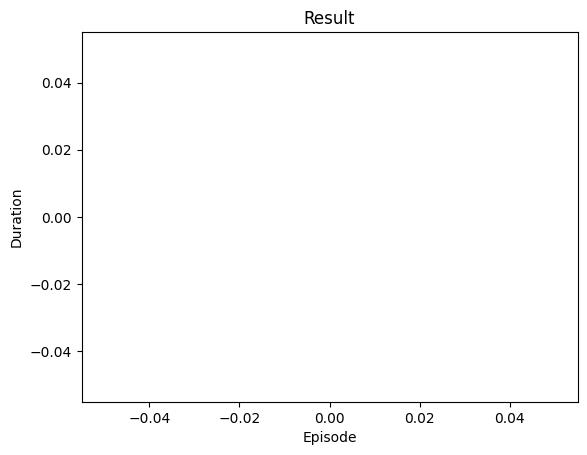

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [106]:
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [33]:
env = BattleshipEnv()
num_episodes = 1

for episode in range(num_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    steps = 0

    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    while not done:
        # action = select_action(state)
        # print(action)
        print(policy_net(state).max(1).indices.view(1, 1))
        obs, reward, done, truncated, _ = env.step(action.item())
        total_reward += reward
        steps += 1
    print(f"Episode {episode+1}: Steps={steps}, Total Reward={total_reward}")

tensor([[77]], device='cuda:0')
tensor([[77]], device='cuda:0')
Episode 1: Steps=2, Total Reward=-6.0
